# Fine Grained Analysis with ResNet34

### Importing Required Libraries

In [ ]:
# %reload_ext autoreload
# %autoreload 2
# %matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
import random
import matplotlib.pyplot as plt

import os
# Needed for Nakul's code
# os.add_dll_directory('C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDNN\\v8.4\\bin') 
# load opencv after the os add dll directory
import cv2 # (uses custom opencv build for NVIDIA GPU)

## Data Preprocessing  
- Downloading and extracting custom datasets  
- Loading custom datasets  
- Calculating the mean and std for normalization on custom datasets  
- Loading transforms to augment and normalize our data  

In [ ]:
# from zipfile import ZipFile
# file_name = ['/content/test - HSV.zip','/content/train - HSV.zip']
# for i in file_name:
#   with ZipFile(i, 'r') as z:
#     z.extractall()
#     print('Done')

### **Make sure to drop grayscale images or any other odd images**

In [ ]:
train_path = "/content/train - HSV"
# if not os.path.exists(train_path):
#     os.makedirs(train_path)

test_path = "/content/test - HSV"
# if not os.path.exists(test_path):
#     os.makedirs(test_path)
classes = ['AnnualCrop','Forest','HerbaceousVegetation','Highway','Industrial','Pasture','PermanentCrop','Residential','River','SeaLake']

In [ ]:
from torchvision.transforms.transforms import CenterCrop


class SquarePad:
    def __call__(self, image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return torchvision.transforms.functional.pad(image, padding, 0, 'constant')


mean = [0.348,0.384,0.411]
std = [0.094,0.067,0.0566]

transform = torchvision.transforms.Compose(
    [
      SquarePad(),
      torchvision.transforms.RandomHorizontalFlip(p = 0.5),
      torchvision.transforms.RandomVerticalFlip(p = 0.5),
      torchvision.transforms.Resize(224),
      #torchvision.transforms.CenterCrop(224),
      #torchvision.transforms.RandomResizedCrop(224, (0.8, 1.0)),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(
          mean=mean,
          std=std
          )
    ]
)

train = torchvision.datasets.ImageFolder(
    root = train_path,
    transform = transform
)


train_loader = torch.utils.data.DataLoader(
    train, 
    batch_size= 64,
    shuffle=True
)

test = torchvision.datasets.ImageFolder(
    root = test_path,
    transform = transform
)


test_loader = torch.utils.data.DataLoader(
    test, 
    batch_size= 64,
    shuffle=True
)

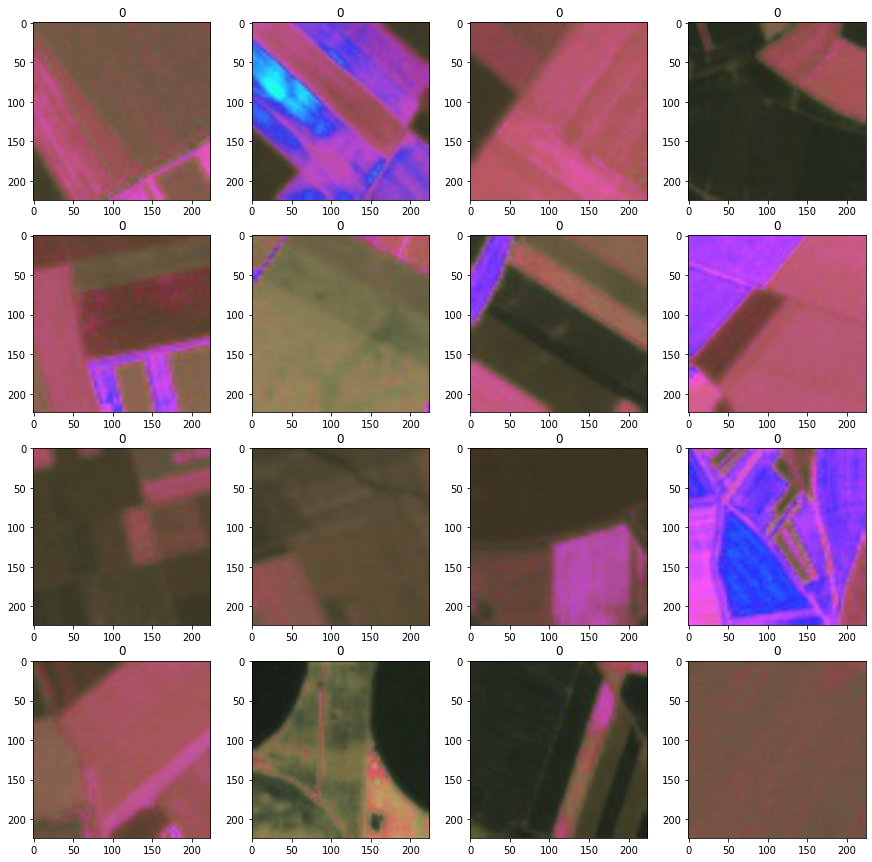

In [ ]:
fig, axes = plt.subplots(4,4,figsize= (15,15))

for i in range(16):

  img = train[i][0].numpy().transpose(1, 2, 0)
  img = np.clip((std * img) + mean, 0, 1)
  axes.flat[i].imshow(img)
  axes.flat[i].set_title(str(train[i][1]))

# Follow aspect ratio of either 1:1 or 1.68:1 (8.5, 4.75/5)
fig.savefig('train_image_transformations.jpg', dpi=300, bbox_inches='tight')  
fig.savefig('train_image_transformations.pdf', dpi=300, bbox_inches='tight')  
plt.show()

### Define Model(ResNet34)
**We will use first 7 layers of ResNet34 model and add 2 custom FC linear layer with batch normalization as shown below**

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet50(weights='ResNet50_Weights.DEFAULT')
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers)
        self.bn1 = nn.BatchNorm1d(2048)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, 200)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flattening 
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        x = self.bn2(x)
        x = self.fc2(x)
        return x

if torch.cuda.is_available():
  cuda = True


ResNet_34 = Net()

if cuda:
  ResNet_34.cuda()

print(ResNet_34)

Net(
  (top_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 25

### Optimizer
We will use **Adam** as our optimizer

In [ ]:
optimizer = optim.SGD(params = ResNet_34.parameters(),   lr= 1e-3, momentum= 0.9 )
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = nn.CrossEntropyLoss()

### Training Loop

In [ ]:
from datetime import datetime
import tqdm as tqdm

EPOCHS = 50  # 50

train_loss = [np.nan]
train_accuracy = [np.nan]
test_loss = [np.nan]
test_accuracy = [np.nan]

ResNet_34.train()

pbar = tqdm.tqdm(total=EPOCHS, position=0, leave=True)
pbar.set_description("EPOCH 1: Training Loss: NA, ")


for epoch in range(EPOCHS):
  total, correct, running_loss = 0, 0, 0

  for batch_idx, (data, target) in enumerate(train_loader):
    ResNet_34.train()
    if cuda:
      data, target = data.cuda(), target.cuda()
    
    optimizer.zero_grad()

    out = ResNet_34(data)

    loss = criterion(out, target)
    loss.backward()
    optimizer.step()

    current_loss = loss.cpu().data.item()
    running_loss += current_loss

    _, predicted = out.max(1)
    total += target.size(0)
    correct += predicted.eq(target).sum().cpu().item()

    pbar.set_description(f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}\t Test Loss: {test_loss[-1]:.3f}\t")

  test_running_loss = 0
  ResNet_34.eval()
  total_test, correct_test = 0,0
  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
      if cuda:
        data, target = data.cuda(), target.cuda()

      out = ResNet_34(data)

      loss = criterion(out, target)

      test_running_loss += loss.cpu().data.item()
      _,test_pred = out.max(1)
      total_test += target.size(0)
      correct_test += test_pred.eq(target).sum().cpu().item()

    LTest = test_running_loss/len(test_loader)

  LTrain = running_loss/len(train_loader)
  accu = 100.*correct/total
  test_acc = 100.*correct_test/total_test
  train_accuracy.append(accu)
  train_loss.append(LTrain)
  test_loss.append(LTest)
  test_accuracy.append(test_acc)

  pbar.set_description(
      f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}\t Test Loss: {test_loss[-1]:.3f}\t")

  pbar.update()

del train_accuracy[0]
del train_loss[0]
del test_loss[0]
del test_accuracy[0]

EPOCH 1: Training Loss: NA, :   0%|          | 0/50 [01:00<?, ?it/s]
EPOCH 50	 Batch Loss: 0.071	  Epoch Loss: 0.087	 Train Acc: 97.870	 Test Loss: 0.456	: 100%|██████████| 50/50 [07:44<00:00,  9.26s/it]

## Model training

In [ ]:
def save_model(m, p):
    torch.save(m.state_dict(), p)
    
def load_model(m, p):
    m.load_state_dict(torch.load(p))

In [ ]:
p = "model1_tmp.pth"
save_model(ResNet_34, str(p))
load_model(ResNet_34, str(p))

### Unfreeze the layers

In [ ]:
def set_trainable_attr(m, b=True):
    for p in m.parameters(): p.requires_grad = b

In [ ]:
def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])

In [ ]:
unfreeze(ResNet_34, 7)
unfreeze(ResNet_34, 6)
unfreeze(ResNet_34, 5)

### Unfreezing few more layers

In [ ]:
load_model(ResNet_34, str(p))
unfreeze(ResNet_34, 4)
unfreeze(ResNet_34, 3)
unfreeze(ResNet_34, 2)

In [ ]:
from datetime import datetime
import tqdm as tqdm

EPOCHS = 50  # 50

train_loss = [np.nan]
train_accuracy = [np.nan]
test_loss = [np.nan]
test_accuracy = [np.nan]

ResNet_34.train()

pbar = tqdm.tqdm(total=EPOCHS, position=0, leave=True)
pbar.set_description("EPOCH 1: Training Loss: NA, ")


for epoch in range(EPOCHS):
  total, correct, running_loss = 0, 0, 0

  for batch_idx, (data, target) in enumerate(train_loader):
    ResNet_34.train()
    if cuda:
      data, target = data.cuda(), target.cuda()
    
    optimizer.zero_grad()

    out = ResNet_34(data)

    loss = criterion(out, target)
    loss.backward()
    optimizer.step()

    current_loss = loss.cpu().data.item()
    running_loss += current_loss

    _, predicted = out.max(1)
    total += target.size(0)
    correct += predicted.eq(target).sum().cpu().item()

    pbar.set_description(f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}\t Test Loss: {test_loss[-1]:.3f}\t")

  test_running_loss = 0
  ResNet_34.eval()
  total_test, correct_test = 0,0
  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
      if cuda:
        data, target = data.cuda(), target.cuda()

      out = ResNet_34(data)

      loss = criterion(out, target)

      test_running_loss += loss.cpu().data.item()
      _,test_pred = out.max(1)
      total_test += target.size(0)
      correct_test += test_pred.eq(target).sum().cpu().item()

    LTest = test_running_loss/len(test_loader)

  LTrain = running_loss/len(train_loader)
  accu = 100.*correct/total
  test_acc = 100.*correct_test/total_test
  train_accuracy.append(accu)
  train_loss.append(LTrain)
  test_loss.append(LTest)
  test_accuracy.append(test_acc)

  pbar.set_description(
      f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}\t Test Loss: {test_loss[-1]:.3f}\t")

  pbar.update()

del train_accuracy[0]
del train_loss[0]
del test_loss[0]
del test_accuracy[0]

EPOCH 50	 Batch Loss: 0.071	  Epoch Loss: 0.087	 Train Acc: 97.870	 Test Loss: 0.456	: 100%|██████████| 50/50 [07:45<00:00,  9.31s/it]
EPOCH 50	 Batch Loss: 0.001	  Epoch Loss: 0.006	 Train Acc: 99.907	 Test Loss: 0.359	: 100%|██████████| 50/50 [13:05<00:00, 15.70s/it]

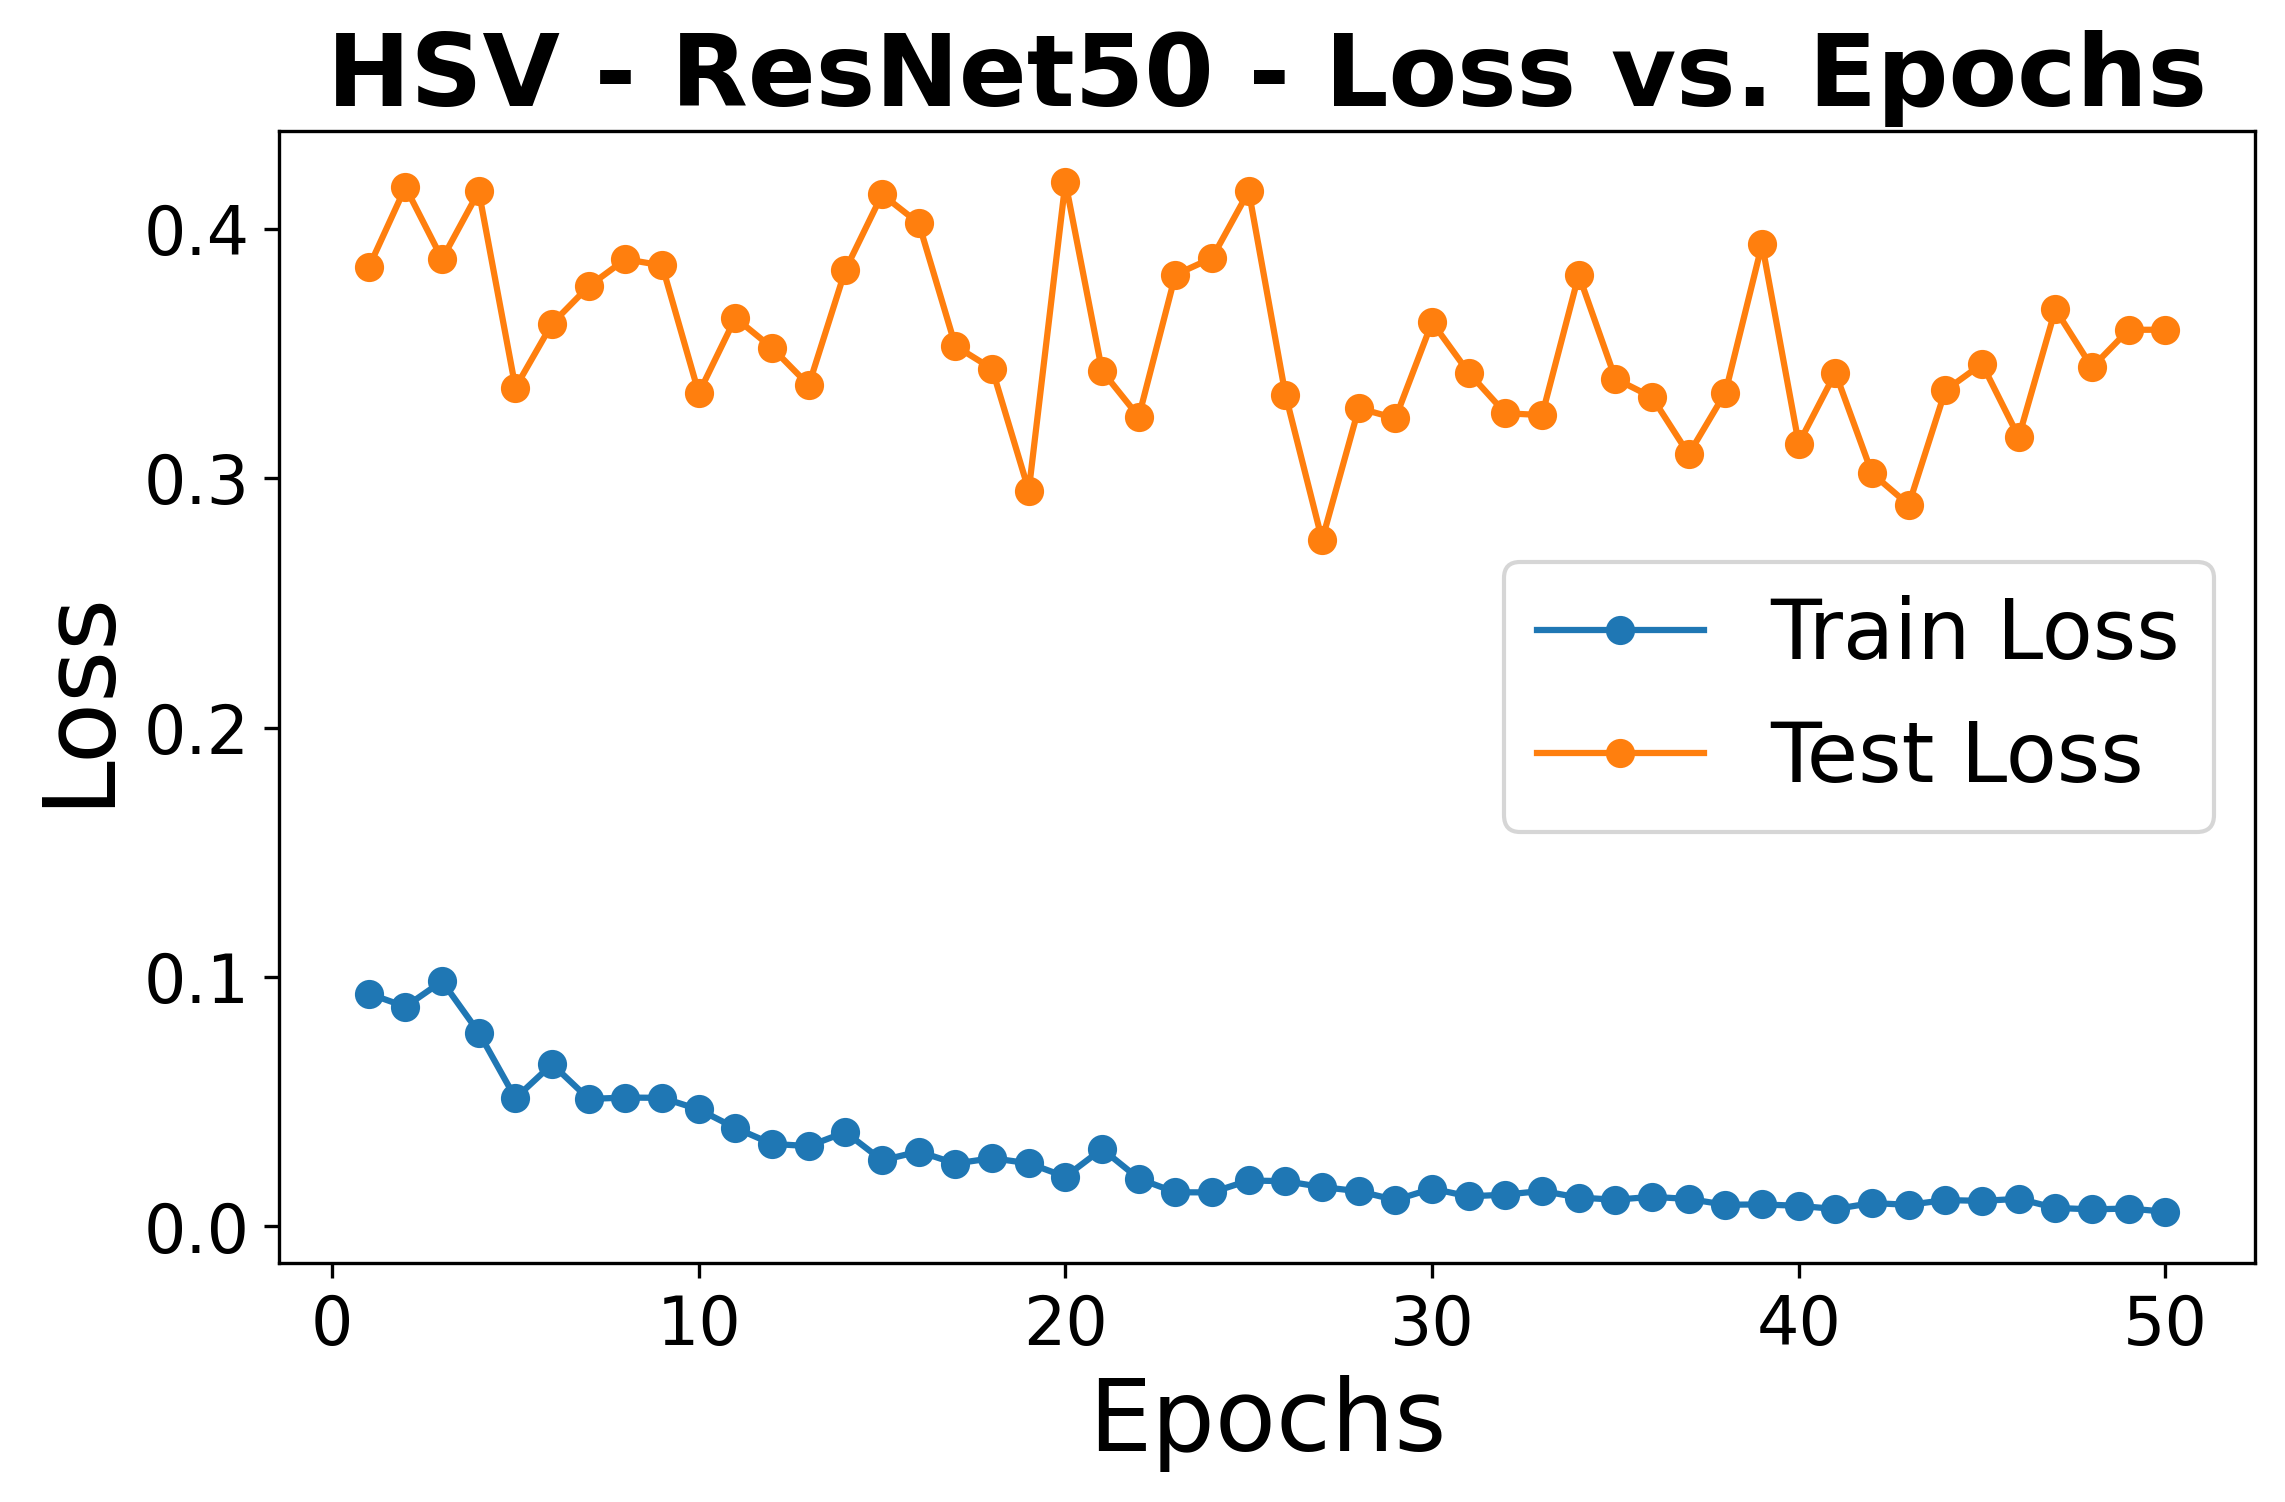

In [ ]:
import seaborn as sns

from matplotlib import RcParams


myrcparams = RcParams({'axes.axisbelow': True,
          'axes.edgecolor': 'white',
          'axes.facecolor': '#EAEAF2',
          'axes.grid': True,
          'axes.labelcolor': '.15',
          'axes.linewidth': 0.0,
          'figure.facecolor': 'white',
          'font.family': ['serif'],
          'grid.color': 'white',
          'grid.linestyle': '--',
          'image.cmap': 'Greys',
          'legend.frameon': False,
          'legend.numpoints': 1,
          'legend.scatterpoints': 1,
          'lines.solid_capstyle': 'round',
          'text.color': '.15',
          'xtick.color': '.15',
          'xtick.direction': 'out',
          'xtick.major.size': 0.0,
          'xtick.minor.size': 0.0,
          'ytick.color': '.15',
          'ytick.direction': 'out',
          'ytick.major.size': 0.0,
          'ytick.minor.size': 0.0})

plt.style.library['seaborn-whitegrid']
RcParams.update(myrcparams)


fig, ax = plt.subplots(figsize =(8.5,5), dpi=300)

x = np.arange(1,len(train_loss)+1)

ax.plot(x, train_loss, '-o', label = "Train Loss", linewidth = 1.5)
ax.plot(x, test_loss, '-o', label = "Test Loss", linewidth = 1.5)

ax.set_xlabel("Epochs", fontsize = 24)
ax.set_ylabel("Loss", fontsize = 24)

ax.tick_params(
    axis = 'both',
    labelsize = 16
)
ax.legend(fontsize = 20)
ax.set_title("HSV - ResNet50 - Loss vs. Epochs", fontsize = 24, fontweight = 'bold')

plt.savefig("HSV_ResNet50_Loss_vs_Epochs.jpg", dpi = 300, bbox_inches = 'tight')
plt.savefig("HSV_ResNet50_Loss_vs_Epochs.pdf", dpi = 300, bbox_inches = 'tight')
plt.show()

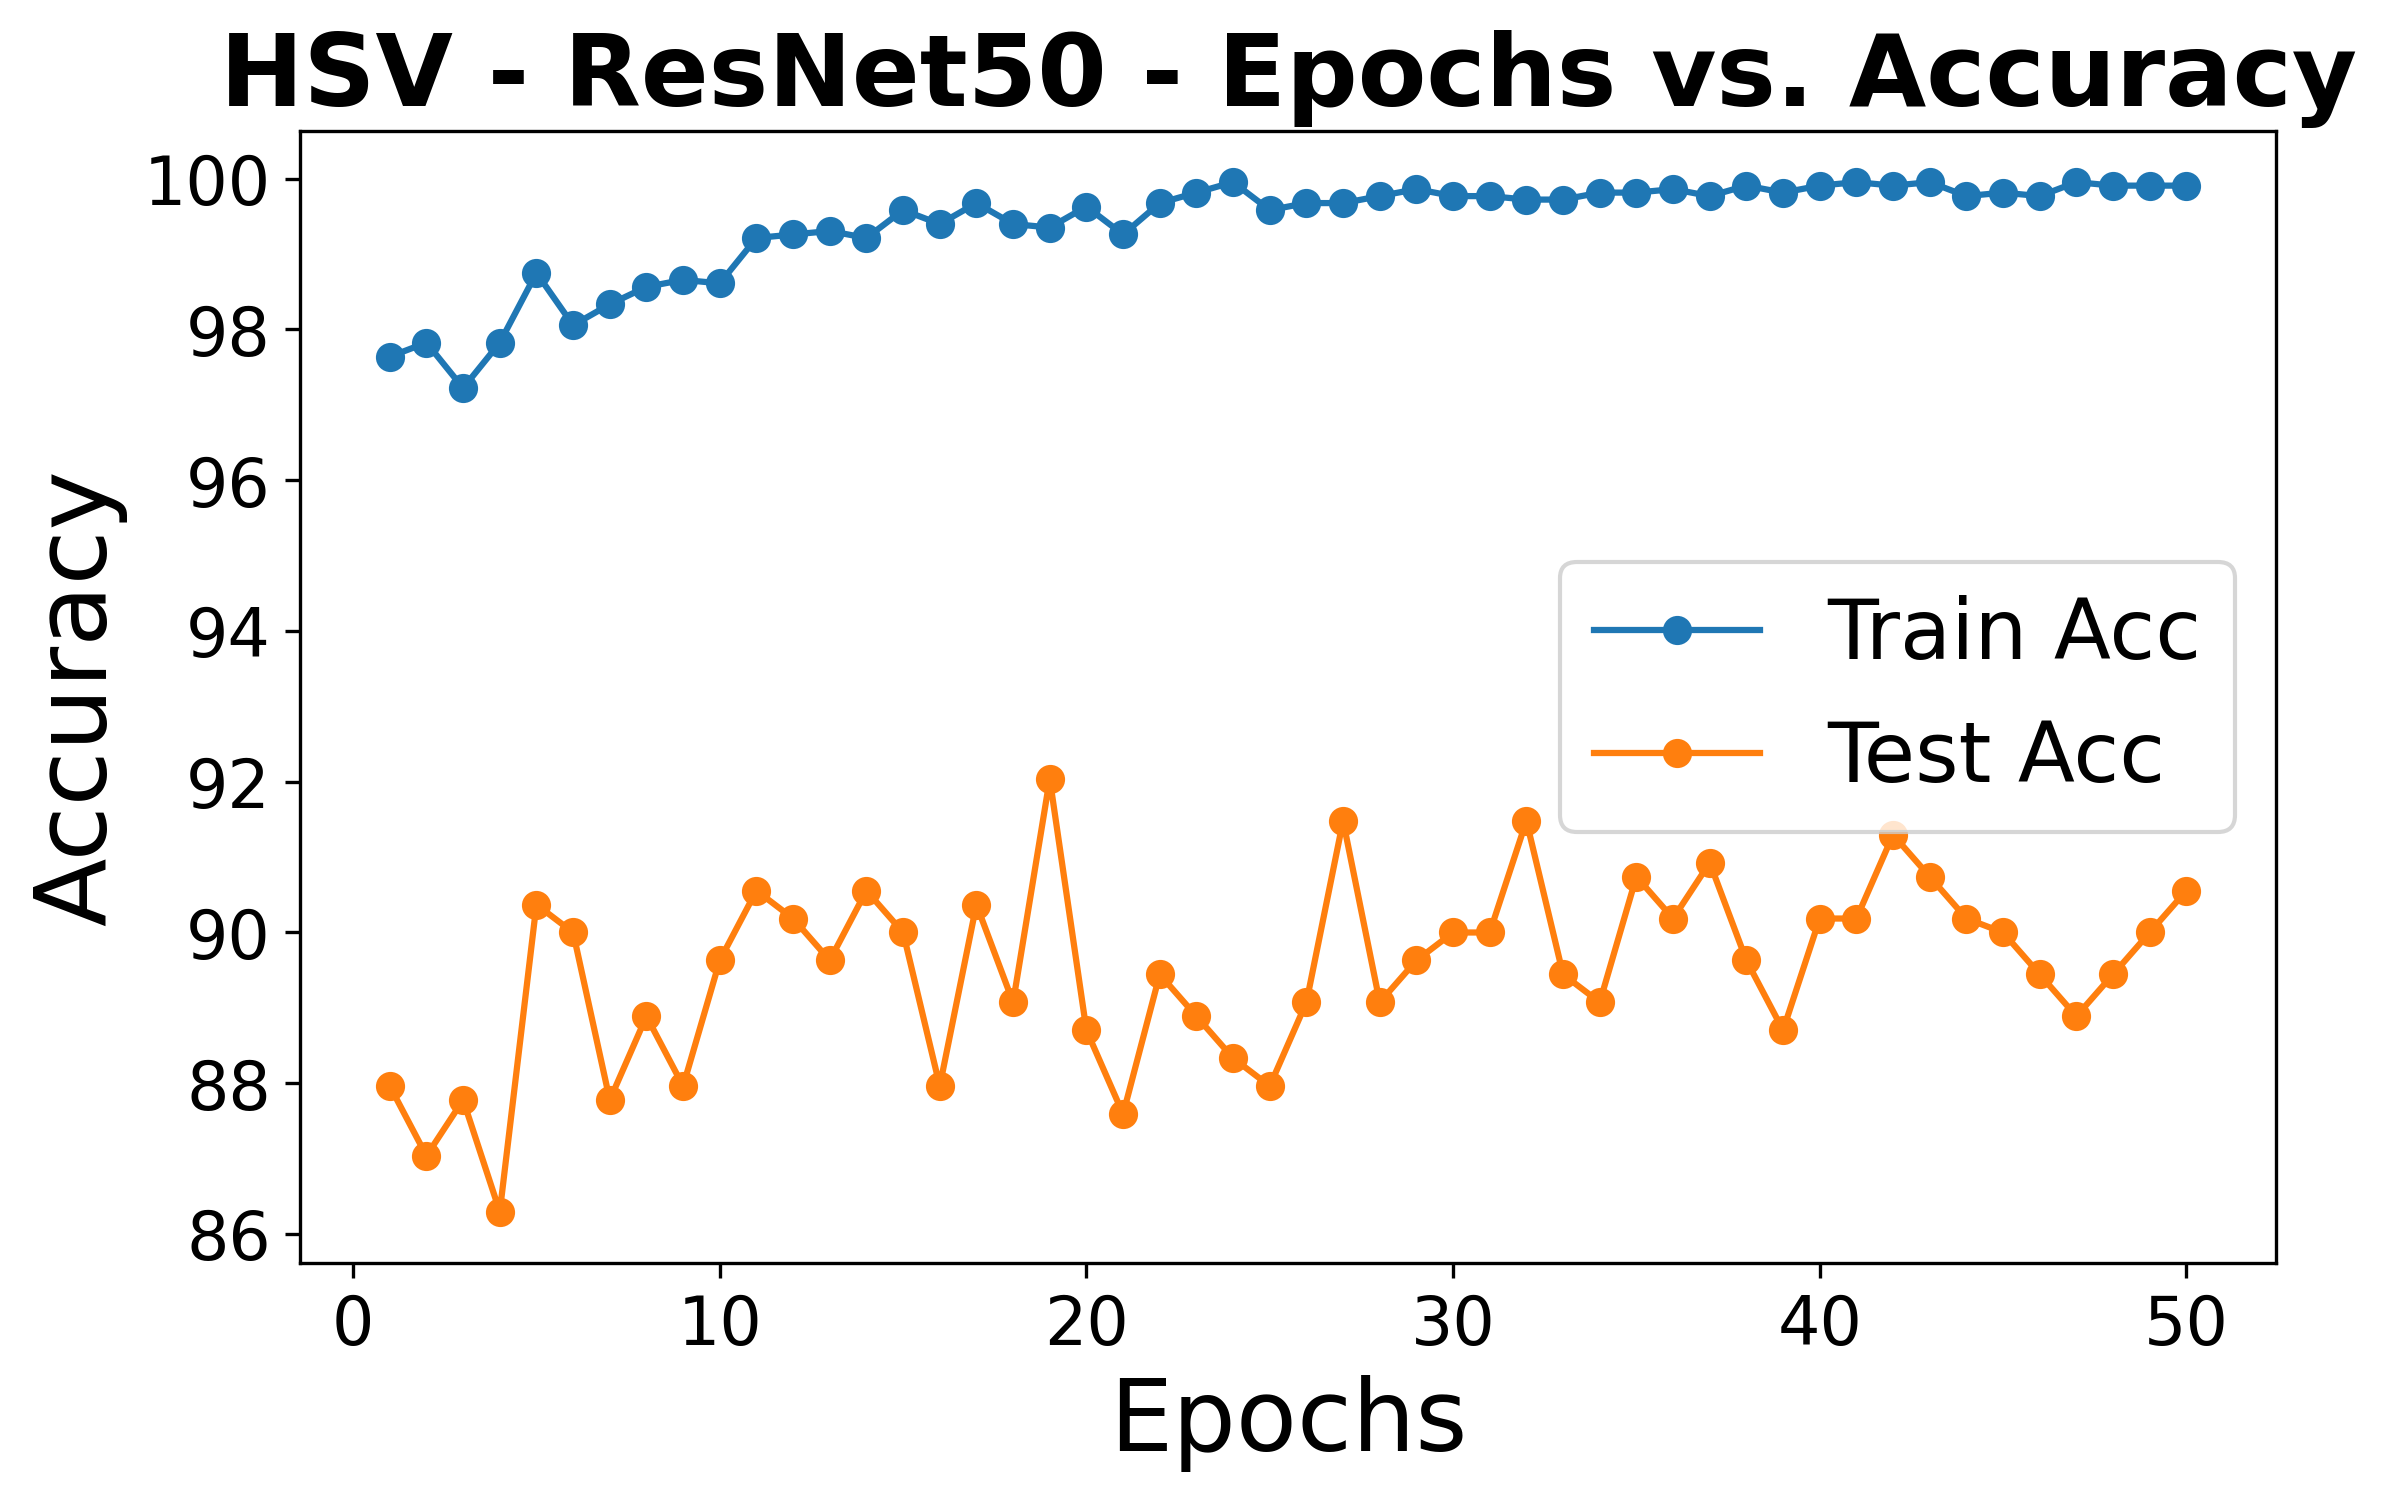

In [ ]:
import seaborn as sns

from matplotlib import RcParams


myrcparams = RcParams({'axes.axisbelow': True,
          'axes.edgecolor': 'white',
          'axes.facecolor': '#EAEAF2',
          'axes.grid': True,
          'axes.labelcolor': '.15',
          'axes.linewidth': 0.0,
          'figure.facecolor': 'white',
          'font.family': ['serif'],
          'grid.color': 'white',
          'grid.linestyle': '--',
          'image.cmap': 'Greys',
          'legend.frameon': False,
          'legend.numpoints': 1,
          'legend.scatterpoints': 1,
          'lines.solid_capstyle': 'round',
          'text.color': '.15',
          'xtick.color': '.15',
          'xtick.direction': 'out',
          'xtick.major.size': 0.0,
          'xtick.minor.size': 0.0,
          'ytick.color': '.15',
          'ytick.direction': 'out',
          'ytick.major.size': 0.0,
          'ytick.minor.size': 0.0})

plt.style.library['seaborn-whitegrid']
RcParams.update(myrcparams)


fig, ax = plt.subplots(figsize =(8.5,5), dpi=300)

x = np.arange(1,len(train_loss)+1)

ax.plot(x, train_accuracy, '-o', label = "Train Acc", linewidth = 1.5)
ax.plot(x, test_accuracy, '-o', label = "Test Acc", linewidth = 1.5)

ax.set_xlabel("Epochs", fontsize = 24)
ax.set_ylabel("Accuracy", fontsize = 24)

ax.tick_params(
    axis = 'both',
    labelsize = 16
)
ax.legend(fontsize = 20)
ax.set_title("HSV - ResNet50 - Epochs vs. Accuracy", fontsize = 24, fontweight = 'bold')

plt.savefig("HSV_ResNet50_Epochs_vs_Accuracy.jpg", dpi = 300, bbox_inches = 'tight')
plt.savefig("HSV_ResNet50_Epochs_vs_Accuracy.pdf", dpi = 300, bbox_inches = 'tight')
plt.show()

## Accuracy Metrics:
The code below is dervied from Pytorch github [code](https://github.com/pytorch/examples/blob/master/imagenet/main.py)

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def accuracy(output, target, top=(1,)):
    """Computes the precision@k for the specified values of k"""
    #with torch.no_grad():
    maxk = max(top)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in top:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [ ]:
def calc_accuracy(model, dataloader):
    model.eval()
    model.cuda()    
    
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    for idx, (inputs, labels) in enumerate(dataloader):
        
        inputs, labels = inputs.cuda().float(), labels.cuda().long()
        # obtain the outputs from the model
        outputs = model.forward(inputs)
        outputs = torch.stack(list(outputs), dim = 0)
        prec1, prec5 = accuracy(outputs, labels, top=(1, 5))
        top1.update(prec1[0], inputs.size(0))
        top5.update(prec5[0], inputs.size(0))
        
    return top1 ,top5

In [ ]:
top1,top5=calc_accuracy(ResNet_34, test_loader)

In [ ]:
top1.avg

tensor(90.3704, device='cuda:0')

In [ ]:
top5.avg

tensor(100., device='cuda:0')

In [ ]:
idx_to_class = inv_map = {v: k for k, v in test.class_to_idx.items()}

correct = []
pred = []

ResNet_34.eval()

with torch.no_grad():
    for batch_idx, (data,target) in enumerate(test_loader):
        if cuda:
          data, target = data.cuda(), target.cuda()
        
        out = ResNet_34(data)


        for _,i in enumerate(out):

            pred.append(torch.argmax(i).cpu().item())
            correct.append(target[_].cpu().item())


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

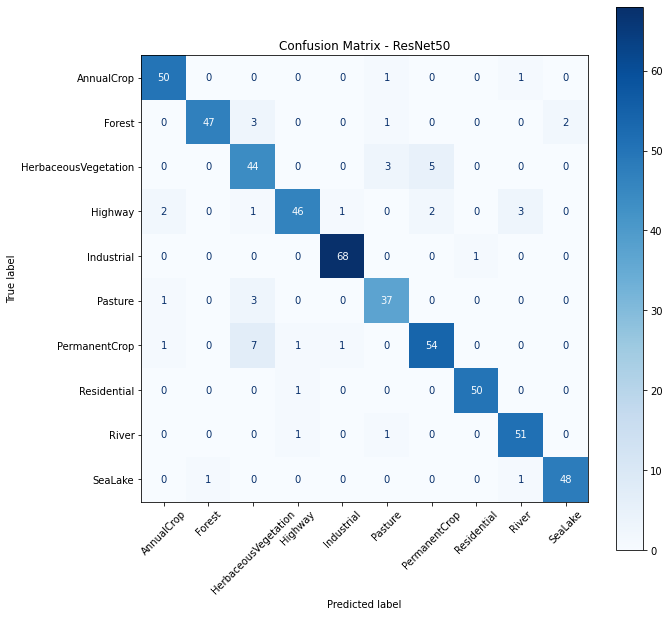

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, plot_confusion_matrix, ConfusionMatrixDisplay
classes = ['AnnualCrop','Forest','HerbaceousVegetation','Highway','Industrial','Pasture','PermanentCrop','Residential','River','SeaLake']

labels = np.arange(0,10)
label_dict = dict(zip(labels,classes))
conf = confusion_matrix(y_pred= pred, y_true = correct)
p = ConfusionMatrixDisplay(conf,display_labels = classes)
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Confusion Matrix - ResNet50')

p.plot(ax=ax,xticks_rotation=45, cmap = "Blues")
plt.savefig('HSV_ResNet50_Confusion_Matrix.jpg',dpi = 300, bbox_inches = 'tight')
plt.savefig('HSV_ResNet50_Confusion_Matrix.pdf',dpi = 300, bbox_inches = 'tight')

x = {'HSV_ResNet50_Train_Acc':train_accuracy,'HSV_ResNet50_Test_Acc':test_accuracy, 'HSV_ResNet50_Train_Loss':train_loss,'HSV_ResNet50_Test_Loss':test_loss,'ResNet_50_Top_1':90.3704,'ResNet_50_Top_5':100}
import pandas as pd
DF = pd.DataFrame.from_dict(x)
DF.to_csv('Accuracy_ResNet50.csv')

download_files = ['HSV_ResNet50_Confusion_Matrix.jpg','HSV_ResNet50_Confusion_Matrix.pdf',"HSV_ResNet50_Loss_vs_Epochs.jpg","HSV_ResNet50_Loss_vs_Epochs.pdf","HSV_ResNet50_Epochs_vs_Accuracy.jpg","HSV_ResNet50_Epochs_vs_Accuracy.pdf",'Accuracy_ResNet50.csv']
from google.colab import files
for i in download_files:
  files.download(i)